In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from utils.class_weights import get_normalized_class_weights
from utils.model_evaluate import ModelEvaluator
from utils.plotter import plot_th_decision
from sklearn.metrics import precision_score, recall_score

# Carregamento dos dados

In [2]:
df = pd.read_csv('../data/02_handling_outliers/data.csv')
print(df.shape)

df.head()

(22742, 14)


,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
0,1919933,NaN,NaN,NaN,1,1,1,0.012500,m_only,0.012500,cartola_free,0.000000,0.000000,0.000000
1,1979452,NaN,NaN,NaN,7,66,10,1.018757,pc_e_m,0.068122,cartola_pro,0.911605,0.000000,0.026530
2,1987950,NaN,NaN,NaN,7,14,6,1.293761,pc_e_m,0.012500,cartola_free,0.000000,0.564663,0.025642
3,1988149,NaN,NaN,NaN,8,49,24,1.995802,pc_only,0.013103,cartola_free,0.357694,0.961152,0.651353
4,1996199,NaN,NaN,NaN,21,75,46,2.845341,pc_e_m,0.026424,cartola_free,0.335683,1.996365,0.219123


Atribuindo labels ao target

In [3]:
df.loc[df['cartola_status'] == 'cartola_free', 'target_cartola_status'] = 0
df.loc[df['cartola_status'] == 'cartola_pro', 'target_cartola_status'] = 1
df.drop(columns=['cartola_status'], inplace=True)

# Preparação dos dados

## Correlação e Feature Engineering

Analisando distribuição do target

In [4]:
df['target_cartola_status'].value_counts(normalize=True) * 100

target_cartola_status
0.0    97.388093
1.0     2.611907
Name: proportion, dtype: float64

Vamos utilizar a correlação de Spearman, pois ela captura relações monotônicas (não apenas lineares) e é mais robusta a outliers

<Axes: >

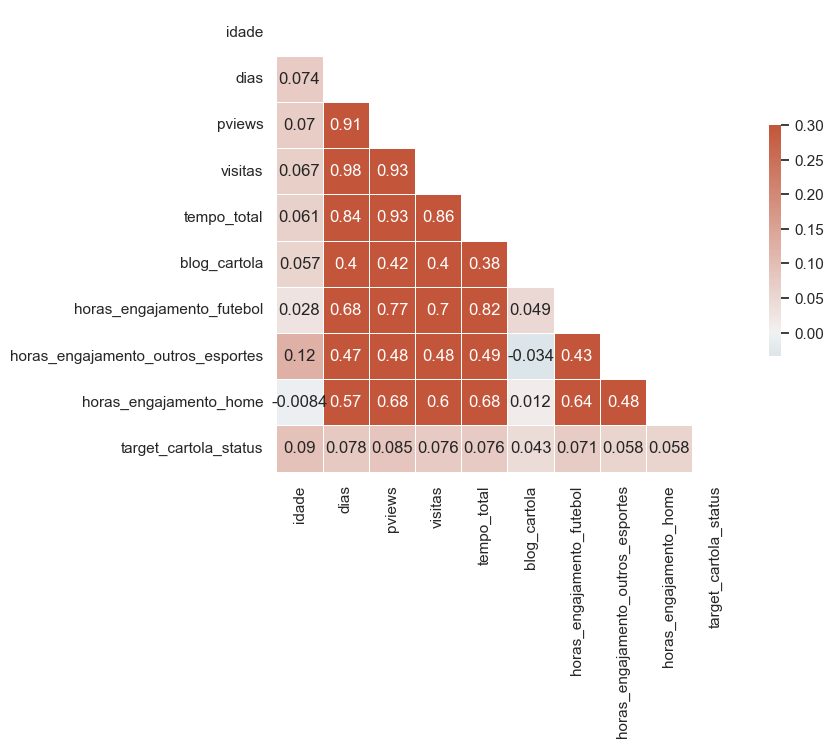

In [5]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Temos muitas features altamente correlatas, vamos reduzir algumas para evitar possível multicolinearidade

In [6]:
# taxa de engajamento
df['taxa_engajamento'] = df['tempo_total'] / df['visitas']

# razão entre a qtd de pviews por visitas
df['pviews_por_visitas'] = df['pviews'] / df['visitas']

# frequencia de visitas
df['frequencia_visitas'] = df['visitas'] / df['dias']

Dropando colunas que não serão mais utilizadas

- coluna UF: Como vimos na análise exploratória, se não há diferença significativa na distribuição de clientes PRO e Free, a variável adiciona ruído sem valor preditivo
Também vamos evitar o problema de criar muitas variáveis dummy.
- coluna devices: vamos retirá-la, pois seu número de missings representa 50% do dataframe, o que pode comprometer a análise, até mesmo na hora de preenchê-los.
- coluna sexo: vimos na análise exploratória que o sexo masculino é predominante, e tbm notamos o alto nível de missing. Nessa primeira etapa, vou retirar essa variável,
  porém, vale a pena testa-la de outras formas futuramente, como por exemplo, imputar os valores nulos com um valor numérico (ex: -1) ou uma categoria representativa ('nao_atribuido').


In [7]:
drop_cols = ['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']
# drop_cols = ['uf', 'device']

df = df.drop(columns=drop_cols)

<Axes: >

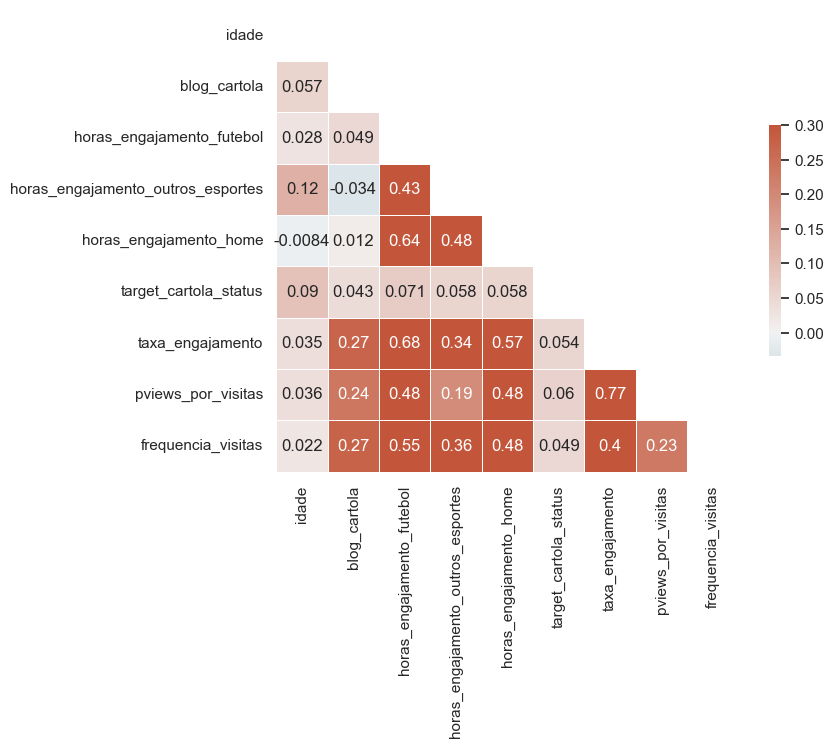

In [8]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Houve uma boa redução na correlação das variáveis.

## Split em treino, validação e teste

In [9]:
df_test = df.sample(frac=.2, random_state=42) # separando 20% para teste

df_train_val = df.drop(df_test.index)

In [10]:
df_train_val.columns

Index(['user', 'idade', 'blog_cartola', 'horas_engajamento_futebol',
       'horas_engajamento_outros_esportes', 'horas_engajamento_home',
       'target_cartola_status', 'taxa_engajamento', 'pviews_por_visitas',
       'frequencia_visitas'],
      dtype='object')

In [11]:
X = df_train_val.drop(columns=['user', 'target_cartola_status'])
y = df_train_val['target_cartola_status']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Column Transformer

In [13]:
# Define as colunas para cada tipo de transformação
cols_num = [
    'idade',
    'taxa_engajamento',
    'pviews_por_visitas',
    'frequencia_visitas',
    'blog_cartola',
    'horas_engajamento_futebol',
    'horas_engajamento_outros_esportes',
    'horas_engajamento_home',
]


# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Primeiro trata missing
    ('scaler', StandardScaler())                    # Depois faz a padronização
])

# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Primeiro trata missing
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))            # Depois faz o encoding
])


# Cria o preprocessador completo usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_num),
        # ('cat', categorical_transformer, cols_cat),
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'taxa_engajamento',
                                  'pviews_por_visitas', 'frequencia_visitas',
                                  'blog_cartola', 'horas_engajamento_futebol',
                                  'horas_engajamento_outros_esportes',
                                  'horas_engajamento_home'])])

Para avaliar o resultado da saída do pré-processamento, basta descomentar as linhas abaixo:

In [14]:
# # treinando
# df_test_preprocessor = X_val.head().copy()
# preprocessor.fit_transform(X_train)

# # transformação
# test_preprocessor_transformed = preprocessor.transform(df_test_preprocessor)

# df_test_preprocessor_transformed = pd.DataFrame(
#     data=test_preprocessor_transformed,
#     columns=preprocessor.get_feature_names_out()  # Ajuste conforme seu pipeline
# )

# display(df_test_preprocessor)
# display(df_test_preprocessor_transformed)

# Experimentos

Objetivo: Ajustar um modelo preditivo simples para identificar os perfis de usuários propensos a assinarem o 
Cartola

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

c:\Users\victo\Documents\recrutamento_globo\case_tecnico\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def plot_precision_recall_curve(y_true: np.ndarray, y_pred: np.ndarray, title: str = 'Precision-Recall Curve') -> None:
    """
    Plots the precision-recall curve for a binary classification model.

    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted probabilities or confidence scores for positive class.
        title (str, optional): Title for the plot. Defaults to 'Precision-Recall Curve'.

    Returns:
        None
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.show()

In [17]:
# Calcula os pesos para os dados de treino
class_weights = get_normalized_class_weights(y_train)
class_weights

{0.0: 0.513041945717307, 1.0: 19.66891891891892}

In [18]:
# calculando o scale pos weights
scale_pos_weight = int(class_weights[1] / class_weights[0])
scale_pos_weight

38

In [19]:
# simples função para chamar o Model Evaluator
def fit_evaluate(model, X_train, y_train, X_val, y_val, th=0.5):
    model.fit(X_train, y_train);

    train_results = ModelEvaluator(model, X_train, y_train, th=th)
    display(train_results.evaluate())

    # Avaliação no conjunto de validação
    val_results = ModelEvaluator(model, X_val, y_val, th=th)
    display(val_results.evaluate())

## Logistic Regression

In [20]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.4,5.1,55.95,993.77,9.35,72.43


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,63.63,5.64,54.72,1008.31,10.23,72.03


In [21]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.02,4.68,68.38,1305.55,8.76,63.78


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.42,5.06,66.04,1337.15,9.4,62.9


## Decision Trees

In [22]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.73,5.65,77.03,1200.05,10.52,66.71


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,60.08,4.49,55.66,1288.62,8.32,64.25


In [23]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.0,4.72,88.65,1649.02,8.97,54.25


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,59.18,3.97,66.98,1736.32,7.49,51.83


## RandomForest

In [24]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,73.75,7.4,70.54,836.02,13.39,76.81


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.41,5.73,49.06,901.34,10.26,74.99


In [25]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,74.48,6.21,80.81,1136.16,11.53,68.48


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.49,5.65,66.04,1192.54,10.42,66.91


Random forest por enquanto está obtendo os melhores resultados, com o mínimo de mudança nos hiperparâmetros. \
Consigo não reduzir muito a f1 enquanto aumento a recall, em comparação com os outros modelos.

## XGboost

**Utilizando Modelos mais robustos para finalidade de comparação**

Alterando max depth

In [26]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,96.07,35.31,96.76,165.42,51.73,95.41


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.24,8.13,18.87,309.03,11.36,91.43


Alterando n estimators

In [27]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                n_estimators=150,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,97.61,55.05,97.3,75.28,70.31,97.91


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,52.02,5.42,8.49,251.58,6.62,93.02


Alterando learning rate

In [28]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                n_estimators=100,
                learning_rate=0.01,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,75.71,5.69,90.54,1382.56,10.71,61.64


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.28,4.6,65.09,1455.02,8.59,59.63


Fica bem complexo chegar ao resultado da random forest sem utilizar alguma ferramenta de tuning de hiperparâmetros.

## LGBM

In [34]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,94.87,27.19,96.49,239.96,42.42,93.34


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.09,6.41,21.7,415.01,9.89,88.49


In [36]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,93.86,22.31,96.49,311.03,36.24,91.37


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.83,6.08,25.47,491.28,9.82,86.37


In [37]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        n_estimators=150,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,96.14,34.79,97.03,169.38,51.21,95.3


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,54.14,5.84,16.04,359.55,8.56,90.02


In [39]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        n_estimators=100,
        learning_rate=0.01,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,78.79,21.13,63.78,251.35,31.74,93.03


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,55.14,6.57,17.92,353.6,9.62,90.19


## Tunando Modelos com Optuna
Essa sessão terá algumas experimentações. Porém todo o resumo da escolha final está na sessão "Seleção de Modelos"

### Random Forest

Vamos tunar inicialmente com um modelo mais simples.

In [40]:
import warnings
warnings.filterwarnings('ignore')

DESCOMENTE A CÉLULA ABAIXO CASO QUEIRA FAZER O TUNING DE HIPERPARÂMETROS UTILIZANDO OPTUNA

In [50]:
# def objective(trial):
            
#     # Profundidade da árvore
#     rf_max_depth = trial.suggest_int('max_depth', 5, 15)
    
#     # Quantidade de estimadores
#     rf_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    
#     # Número mínimo de amostras necessárias para dividir um nó, ajudando a controlar o tamanho das árvores.
#     rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
#     # Número mínimo de amostras em uma folha, evitando que a árvore cresça excessivamente.
#     rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    
#     classifier_obj = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', RandomForestClassifier(
#             max_depth=rf_max_depth
#             , n_estimators=rf_n_estimators
#             , class_weight=class_weights))
#     ])
    
#     classifier_obj.fit(X_train, y_train)
    
#     predictions = classifier_obj.predict(X_val)
#     metric = recall_score(y_val, predictions)
    
#     return metric

# # otimizando durante 300 segundos (5 minutos)
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, timeout=300)


[I 2024-10-28 14:39:48,206] A new study created in memory with name: no-name-244799cf-0e5c-4afd-b6f0-9ec430083ed2
[I 2024-10-28 14:39:51,468] Trial 0 finished with value: 0.2169811320754717 and parameters: {'max_depth': 8, 'n_estimators': 312, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:04,418] Trial 1 finished with value: 0.04716981132075472 and parameters: {'max_depth': 11, 'n_estimators': 939, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:13,010] Trial 2 finished with value: 0.16981132075471697 and parameters: {'max_depth': 9, 'n_estimators': 812, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:17,084] Trial 3 finished with value: 0.2169811320754717 and parameters: {'max_depth': 8, 'n_estimators': 397, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with val

In [20]:
# best params:
parameters = {'max_depth': 5, 'n_estimators': 702, 'min_samples_split': 20, 'min_samples_leaf': 2}

rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                # **study.best_params,
                **parameters,
                class_weight=class_weights, 
                random_state=42,
            ))
        ])

rf_model.fit(X_train, y_train)
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.45)
rf_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,65.75,5.43,66.04,1244.05,10.03,65.49


In [78]:
plot_th_decision(rf_model, X_val, y_val, th_atual=0.42)
# o melhor th é 0.42
# descer para 0.4 tem o ganho 0.71 para 0.72 em recall, porém a precision
# cai de 0.05 para 0.046
# subir para 0.44 tem o decaimento de recall em 0.71 para 0.66
# porém o ganho de precision é marginal: 0.05 para 0.051


Valores por Threshold:
 Threshold  Precision  Recall
      0.26      0.034   0.887
      0.28      0.036   0.849
      0.30      0.037   0.802
      0.32      0.038   0.774
      0.34      0.040   0.774
      0.36      0.043   0.774
      0.38      0.045   0.745
      0.40      0.047   0.726
      0.42      0.050   0.717
      0.44      0.052   0.670
      0.46      0.056   0.651
      0.48      0.061   0.613
      0.50      0.060   0.528
      0.52      0.060   0.453
      0.54      0.060   0.377
      0.56      0.062   0.330
      0.58      0.055   0.245


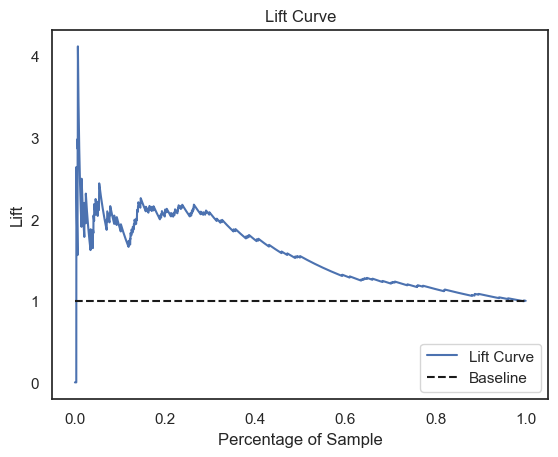

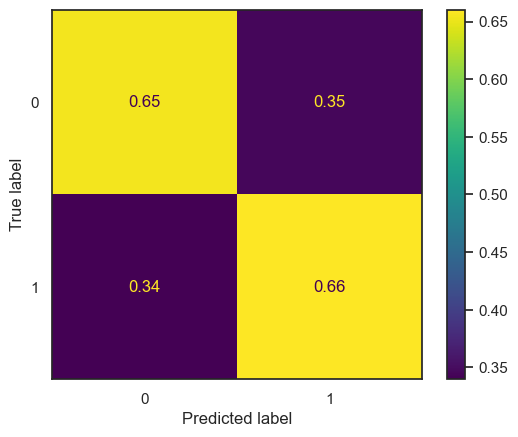

In [57]:
rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

In [58]:
th = 0.45
y_probas = rf_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

In [59]:
th = 0.45
y_probas = rf_model.predict_proba(X_val)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)

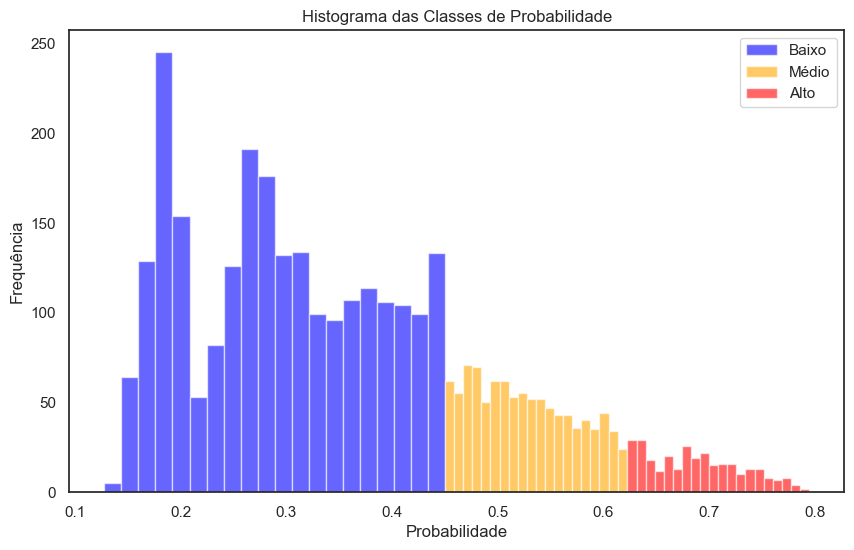

In [60]:
import numpy as np
import matplotlib.pyplot as plt

y_probas = rf_model.predict_proba(X_val)[:, 1]

# Definindo os thresholds para classificação em baixo, médio e alto
th_low = 0.45

# Média entre o threshold baixo e o valor máximo
th_mid = (0.45 + y_probas.max()) / 2  

# Classificando as probabilidades
y_class = np.where(y_probas < th_low, 'baixo', 
                   np.where(y_probas < th_mid, 'médio', 'alto'))

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.hist(y_probas[y_class == 'baixo'], bins=20, color='blue', alpha=0.6, label='Baixo')
plt.hist(y_probas[y_class == 'médio'], bins=20, color='orange', alpha=0.6, label='Médio')
plt.hist(y_probas[y_class == 'alto'], bins=20, color='red', alpha=0.6, label='Alto')
plt.xlabel("Probabilidade")
plt.ylabel("Frequência")
plt.title("Histograma das Classes de Probabilidade")
plt.legend()
plt.show()


Test

In [61]:
drop_cols

['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']

In [62]:
X_test = df_test.drop(columns=['user', 'target_cartola_status'])
y_test = df_test['target_cartola_status']

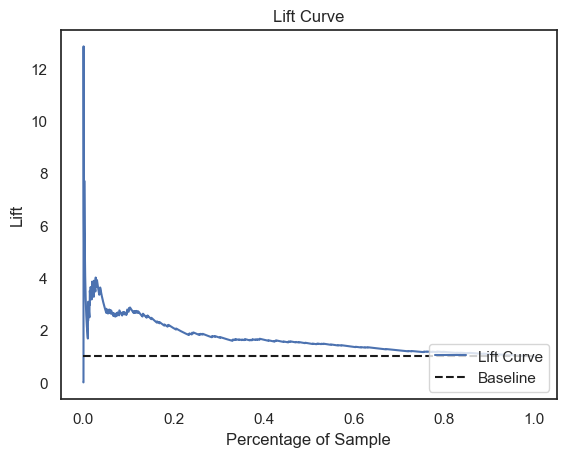

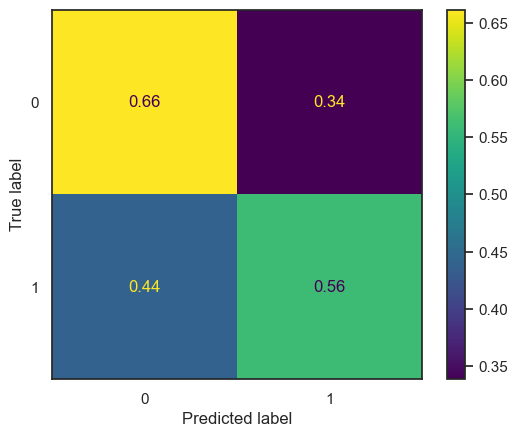

In [65]:
th = 0.45
y_probas = rf_model.predict_proba(X_test)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)


rf_eval = ModelEvaluator(rf_model, X_test, y_test, th=th)
rf_eval.evaluate()

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

### XGBoost

O próximo passo é testar com um modelo mais robusto

In [195]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',  # ou 'multi:softmax' para múltiplas classes
        'eval_metric': 'logloss',        # Métrica de avaliação
        'max_depth': trial.suggest_int('max_depth', 5, 15),  # Profundidade máxima da árvore
        'subsample': trial.suggest_float('subsample', 0.25, 0.65),  # Fração de amostras
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'n_jobs': -1,  # Usar todos os núcleos
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 38, 40),
        'random_state': 42
    }
    
    classifier_obj = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**params))
    ])
    
    
    # 2. Treine o modelo com os dados de treino
    classifier_obj.fit(X_train, y_train)
    
    # 3. Faça previsões e calcule a métrica
    predictions = classifier_obj.predict(X_val)
    metric = recall_score(y_val, predictions)
    
    return metric

# 4. Crie um objeto de estudo e otimize a função objetivo.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

[I 2024-10-28 18:50:26,352] A new study created in memory with name: no-name-8dc5d468-5e21-4257-8c70-32b08b6ec773
[I 2024-10-28 18:50:29,060] Trial 0 finished with value: 0.08490566037735849 and parameters: {'max_depth': 5, 'subsample': 0.3496335866172028, 'learning_rate': 0.485023281354924, 'n_estimators': 890, 'scale_pos_weight': 40}. Best is trial 0 with value: 0.08490566037735849.
[I 2024-10-28 18:50:35,254] Trial 1 finished with value: 0.02830188679245283 and parameters: {'max_depth': 8, 'subsample': 0.44657389256353497, 'learning_rate': 0.24829267452549852, 'n_estimators': 1274, 'scale_pos_weight': 39}. Best is trial 0 with value: 0.08490566037735849.
[I 2024-10-28 18:50:37,072] Trial 2 finished with value: 0.1320754716981132 and parameters: {'max_depth': 6, 'subsample': 0.6098955413195752, 'learning_rate': 0.03804584464432042, 'n_estimators': 377, 'scale_pos_weight': 38}. Best is trial 2 with value: 0.1320754716981132.
[I 2024-10-28 18:50:41,251] Trial 3 finished with value: 0.0

In [196]:
study.best_params

{'max_depth': 5,
 'subsample': 0.6049846419258408,
 'learning_rate': 0.010126892807893475,
 'n_estimators': 200,
 'scale_pos_weight': 39}

In [206]:
# descomentar para usar best params de forma automatica
# xgb_model = Pipeline([
#             ('preprocessor', preprocessor),
#             ('classifier', XGBClassifier(
#                 **study.best_params,
#                 random_state=42,
#             ))
#         ])

# best params
params = {
    'max_depth': 5,
    'subsample': 0.6049846419258408,
    'learning_rate': 0.010126892807893475,
    'n_estimators': 200,
    'scale_pos_weight': 39
 }

xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                **params,
                random_state=42,
            ))
        ])

xgb_model.fit(X_train, y_train)
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.42)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,63.84,5.07,63.21,1281.68,9.38,64.44


In [207]:
plot_th_decision(xgb_model, X_val, y_val, th_atual=0.42)

# tentando manter precision na casa dos 5, o valor mantido para th será 42
# ao diminui-lo iremos perder muito da precision.
# ao aumentar, perderemos consideramente na recall e o ganho de precision é marginal


Valores por Threshold:
 Threshold  Precision  Recall
      0.26      0.038   0.868
      0.28      0.039   0.821
      0.30      0.040   0.764
      0.32      0.042   0.745
      0.34      0.044   0.726
      0.36      0.046   0.717
      0.38      0.046   0.679
      0.40      0.048   0.651
      0.42      0.051   0.632
      0.44      0.052   0.585
      0.46      0.056   0.575
      0.48      0.056   0.519
      0.50      0.062   0.500
      0.52      0.063   0.434
      0.54      0.063   0.377
      0.56      0.067   0.349
      0.58      0.070   0.292


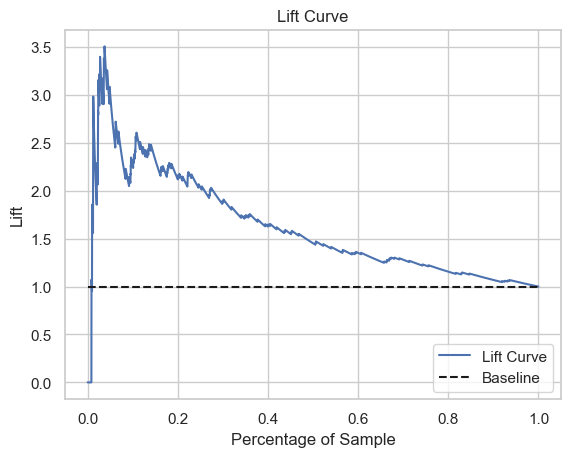

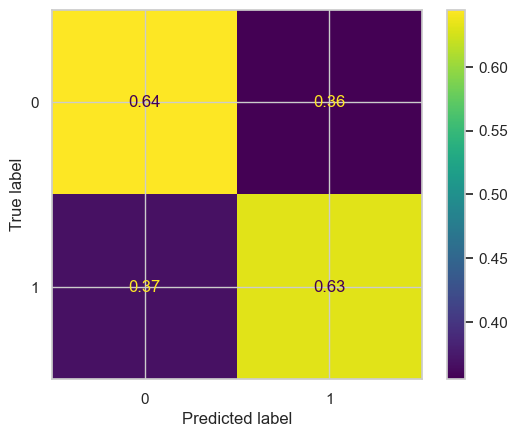

In [209]:
th = 0.42
y_probas = xgb_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

xgb_eval_final = ModelEvaluator(xgb_model, X_val, y_val, th=th)
xgb_eval_final.evaluate()

xgb_eval_final.plot_lift()

xgb_eval_final.plot_confusion_matrix(normalize='true')

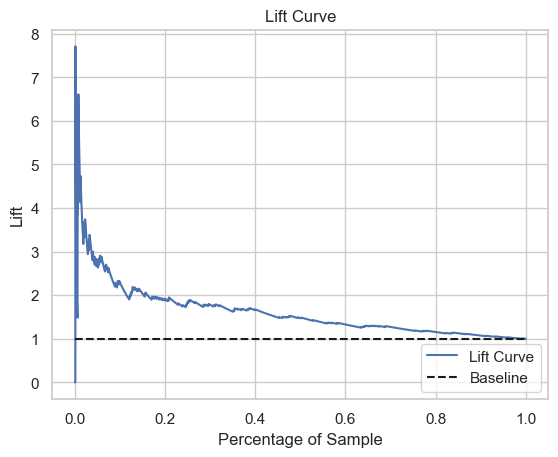

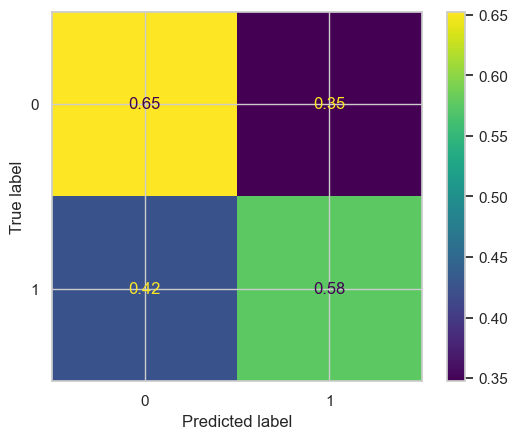

In [210]:
th = 0.42
y_probas = xgb_model.predict_proba(X_test)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)


rf_eval = ModelEvaluator(xgb_model, X_test, y_test, th=th)
rf_eval.evaluate()

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

# Seleção do modelo

O RandomForest adequou melhor no dataset de validação e dataset de teste.

## Conjunto de validação

### Random Forest

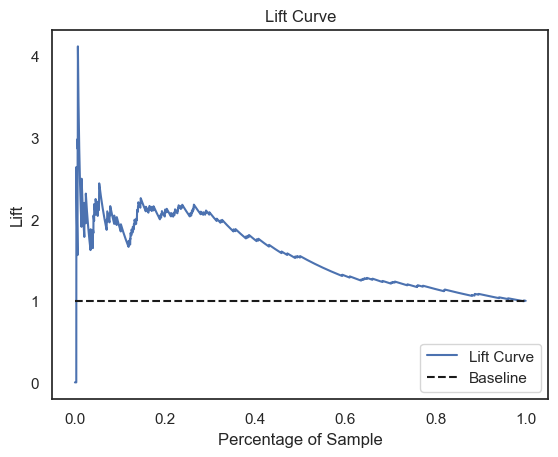

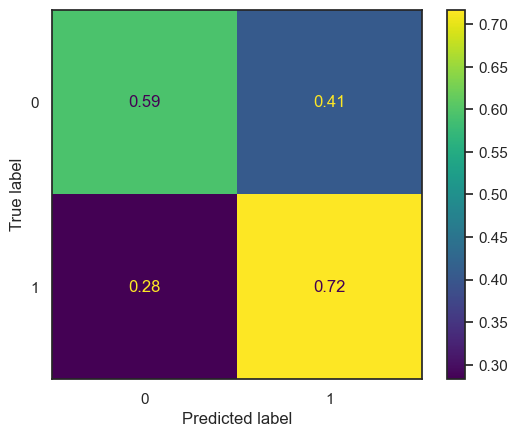

In [21]:
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.42)

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

<Axes: >

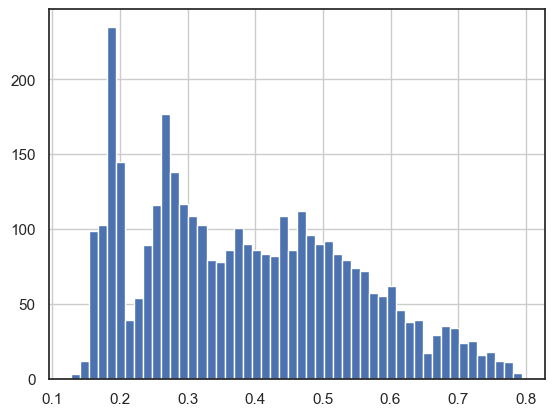

In [22]:
y_val_probas = y_val_pred = rf_model.predict_proba(X_val)[:, 1]

df_rf_results = pd.DataFrame({
    'y_true': y_val,
    'y_pred': y_val_probas
    }
)

df_rf_results = df_rf_results.sort_values('y_pred', ascending=False).reset_index(drop=True)
df_rf_results['y_pred'].hist(bins=50)

### XGBoost

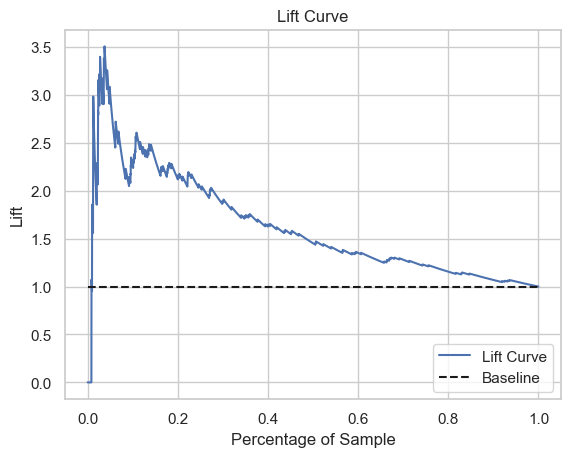

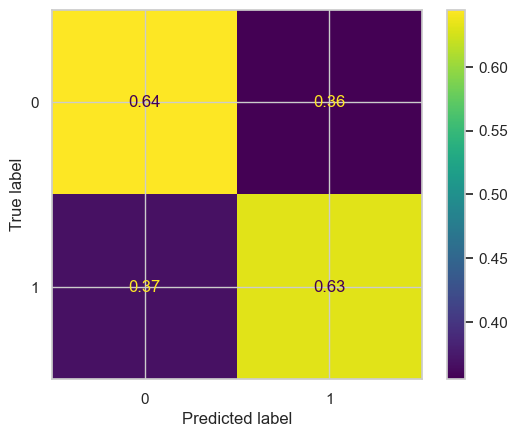

In [218]:
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.42)

xgb_eval.plot_lift()

xgb_eval.plot_confusion_matrix(normalize='true')

<Axes: >

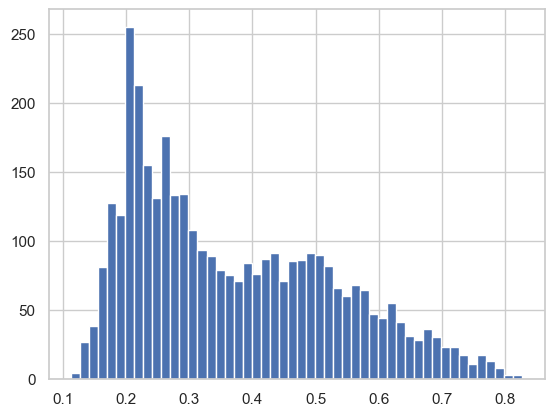

In [219]:
y_val_probas = y_val_pred = xgb_model.predict_proba(X_val)[:, 1]

df_rf_results = pd.DataFrame({
    'y_true': y_val,
    'y_pred': y_val_probas
    }
)

df_rf_results = df_rf_results.sort_values('y_pred', ascending=False).reset_index(drop=True)
df_rf_results['y_pred'].hist(bins=50)

## Conjunto de Teste

### Random Forest

In [23]:
rf_eval = ModelEvaluator(rf_model, X_test, y_test, th=0.42)
rf_eval.plot_confusion_matrix(normalize='true')

NameError: name 'X_test' is not defined

### XGBoost

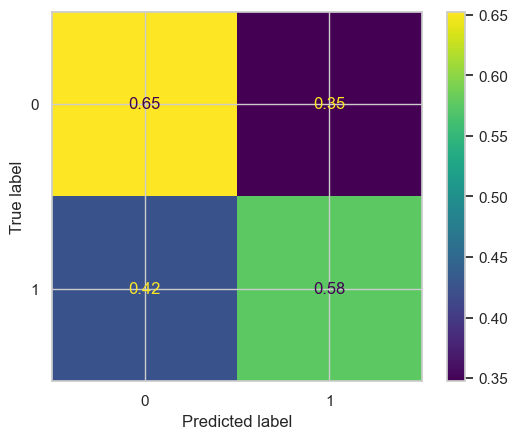

In [221]:
xgb_eval = ModelEvaluator(xgb_model, X_test, y_test, th=0.42)
xgb_eval.plot_confusion_matrix(normalize='true')

# Salvando o Modelo Selecionado

Treinando o modelo e salvando o artefato.

In [24]:
parameters = {'max_depth': 5, 'n_estimators': 702, 'min_samples_split': 20, 'min_samples_leaf': 2}

rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                **parameters,
                class_weight=class_weights, 
                random_state=42,
            ))
        ])

rf_model.fit(X_train, y_train)
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.42)
rf_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,65.57,5.04,71.7,1449.08,9.41,59.8


In [25]:
from joblib import dump, load
dump(rf_model, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [26]:
# testando
load('../models/random_forest.joblib')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'taxa_engajamento',
                                                   'pviews_por_visitas',
                                                   'frequencia_visitas',
                                                   'blog_cartola',
                                                   'horas_engajamento_futebol',
                                                   'horas_engajamento_outros_esportes',
                                                   'horas_engajamento_home'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0.0: 0.513041945717307,
                                                      1.0: 19.66891891891892},
                                        max_depth=5, min_samples_leaf=2,
                                        min_samples_split=20, n_estimators=702,
                                        random_state=42))])

## Justificativa de Escolha: RandomForest

**Conclusão**: O RandomForest demonstra melhor capacidade de generalização e performance superior na métrica principal (identificação de conversões). Como o intuito é desenvolver um modelo simples, porém que solucione o problema de negócio, a utilização do random forest é melhor, principalmente devido a menor exigencia de esforço durante a etapa de ajuste de hiperparâmetros, quando comparamos com o xgboost.
Como o dataset é desbalanceado, há o problema do aumento nos falsos positivos e a compensação na captura de mais de conversões. Nesse caso, vamos tomar a estratégia de que o custo de perder uma conversão e gerar receita pode ser maior que o custo de abordar falsos positivos com campanhas de marketing, já que o produto é recorrente. Embora os resultados de validação sejam bons, os números de teste fornecem melhor estimativa do desempenho real esperado em produção.

# Criando níveis de ação baseado nos scores

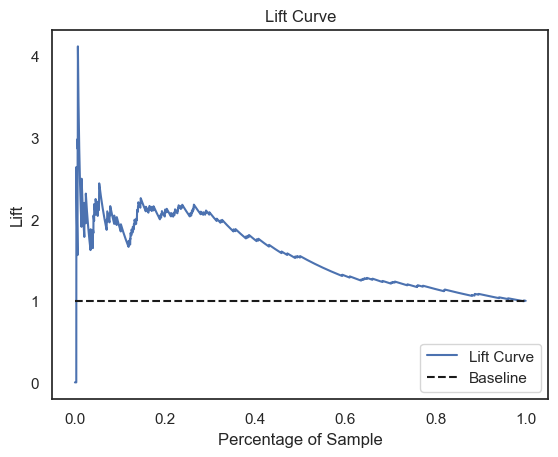

In [27]:
rf_model = load('../models/random_forest.joblib')

rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.45)

rf_eval.plot_lift()

In [30]:
# Previsões de probabilidade
y_val_probas = rf_model.predict_proba(X_val)[:, 1]

In [31]:
# Criação do DataFrame de resultados
df_results = pd.DataFrame({
    'y_true': y_val,
    'y_probas': y_val_probas.round(2)
})

# Define o corte em 0.42 e divide o restante em dois grupos
# Encontra o ponto médio entre 0.42 e o máximo para dividir entre médio e alto
medio_corte = (0.42 + df_results['y_probas'].max()) / 2

# Cria os bins de corte
bins = [-float('inf'), 0.42, medio_corte, float('inf')]
labels = ['BAIXO', 'MÉDIO', 'ALTO']

# Aplica a segmentação
df_results['segment'] = pd.cut(df_results['y_probas'], 
                             bins=bins,
                             labels=labels)

df_results.head()

,y_true,y_probas,segment
10081,0.0,0.64,ALTO
20029,0.0,0.35,BAIXO
10841,0.0,0.21,BAIXO
15069,0.0,0.35,BAIXO
5380,0.0,0.41,BAIXO


Calculando métricas de conversão

In [33]:
# Calcula as métricas por segmento
df_metrics = (
    df_results
    .groupby('segment')
    .agg({
        'y_probas': ['count', 'mean', 'min', 'max']
        , 'y_true': ['sum', 'mean']
        }).round(3)
)

# Renomeia as colunas
df_metrics.columns = ['qtd_clientes'
                     , 'prob_media'
                     , 'prob_min', 'prob_max'
                     , 'conversoes', 'taxa_conversao']

# Resetar índice
df_metrics = df_metrics.reset_index()

# Calcular lift
base_rate = df_results['y_true'].mean()
df_metrics['lift'] = (df_metrics['taxa_conversao'] / base_rate).round(2)

# Ordenar os segmentos na ordem correta
df_metrics = (
    df_metrics
    .sort_values('prob_media', ascending=False)
    .reset_index(drop=True)
)

df_metrics['percentual_clientes'] = 100 * df_metrics['qtd_clientes'] / df_metrics['qtd_clientes'].sum()
df_metrics['percentual_clientes'] = df_metrics['percentual_clientes'].round(2)
df_metrics.head()

C:\Users\victo\AppData\Local\Temp\ipykernel_32696\289161351.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('segment')


,segment,qtd_clientes,prob_media,prob_min,prob_max,conversoes,taxa_conversao,lift,percentual_clientes
0,ALTO,357,0.676,0.61,0.79,20.0,0.056,1.92,9.81
1,MÉDIO,1116,0.507,0.43,0.60,55.0,0.049,1.68,30.67
2,BAIXO,2166,0.279,0.13,0.42,31.0,0.014,0.48,59.52


In [34]:
fig_lift = px.histogram(
    df_metrics, 
    x='segment', 
    y='lift',
    color='segment',
    width=450,
    height=400,
    text_auto='.3s'
)

fig_lift.update_layout(
    title='Lift por Segmento',
    xaxis_title='Segmento',
    yaxis_title='Lift',
    showlegend=True,
    bargap=0.2
)

# Desenha uma linha horizontal em y=1
fig_lift.add_hline(
    y=1, 
    line_dash="dash", 
    line_color="red", 
    opacity=0.5
)

fig_lift.show()

In [35]:
# Gráfico da Taxa de Conversão
fig_conv = px.histogram(
    df_metrics, 
    x='segment', 
    y='taxa_conversao',
    color='segment',
    width=450,
    height=400,
    text_auto='taxa_conversao'
)

fig_conv.update_layout(
    title='Taxa de Conversão por Segmento',
    xaxis_title='Segmento',
    yaxis_title='Taxa de Conversão',
    showlegend=True,
    bargap=0.2
)

fig_conv.show()

In [36]:
fig = px.histogram(
    df_results,
    x='y_probas',
    color='segment',
    barmode='overlay',
    opacity=1,
    width=800,
    height=500,
    title='Distribuição de Probabilidades por Segmento',
    labels={'y_probas': 'Probabilidade de Conversão', 'count': 'Quantidade de Clientes'},
    template='plotly_white',
    color_discrete_sequence=px.colors.qualitative.Alphabet
)

# Ajustes finais
fig.update_traces(xbins=dict(size=0.02))
fig.update_layout(bargap=0.1, legend=dict(orientation='h', y=-0.2))

fig.show()